# Cookbook: Precipitation return times for Hurricane Harvey

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
# These are some parameters to make figures nice (and big)

plt.rcParams['figure.figsize'] = 16,8
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Houston precipitation
In the wake of Hurricane Harvey, many have described the assocaited flooding as a "500-year event". How can this be, given that in most places there are only a few decades of data available? In this exercise we apply a simple (and most likely wrong) methodology to estimate _return periods_, and comment on the wisdom of that concept.

Let's load and get to know the data. We are looking at daily precip data (in cm) at Beaumont Research Center and Port Arthur, two of the weather stations in the Houston area that reported very high daily precip totals. 

The data comes from NOAA GHCN:<br>
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00410613/detail<br>
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00012917/detail


In [3]:
# read data and take a cursory look
df=pd.read_csv('https://raw.githubusercontent.com/cdds-uiuc/simles-book/main/content/Module02/data/Beaumont_precip.csv')

df.head()

STATION                        NAME        DATE  DAPR  MDPR  PRCP
0  USC00410613  BEAUMONT RESRCH CTR, TX US  1947-09-01   NaN   NaN   NaN
1  USC00410613  BEAUMONT RESRCH CTR, TX US  1947-09-02   NaN   NaN   NaN
2  USC00410613  BEAUMONT RESRCH CTR, TX US  1947-09-03   NaN   NaN   NaN
3  USC00410613  BEAUMONT RESRCH CTR, TX US  1947-09-04   NaN   NaN   NaN
4  USC00410613  BEAUMONT RESRCH CTR, TX US  1947-09-05   NaN   NaN   NaN

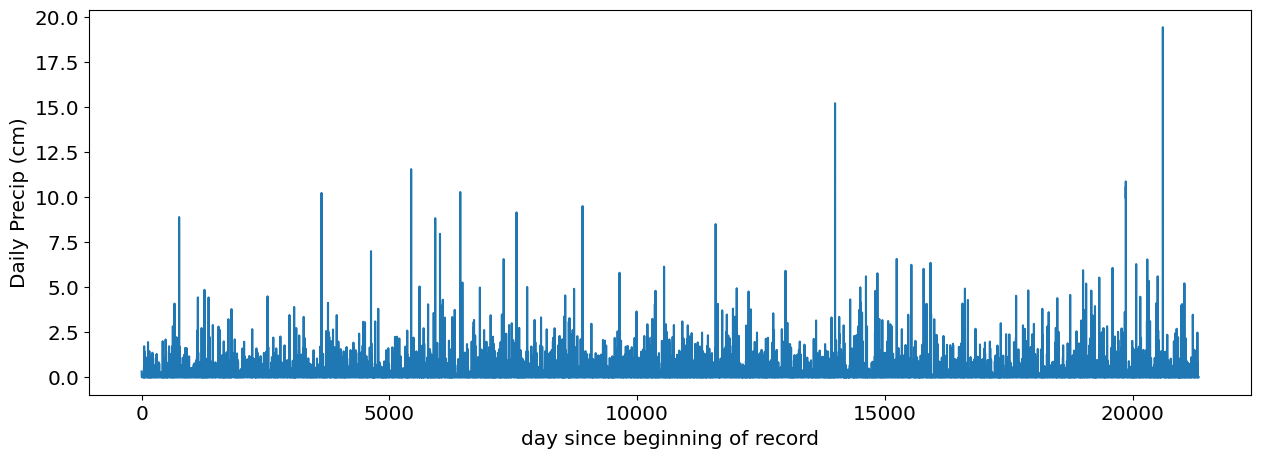

In [11]:
# plot raw precipitation
precip_raw=df['PRCP'].values
precip_raw=precip_raw[np.isnan(precip_raw)==False] # take out nans

fig,ax=plt.subplots(1,1)
ax.plot(precip_raw)
ax.set_xlabel('day since beginning of record')
ax.set_ylabel('Daily Precip (cm)');

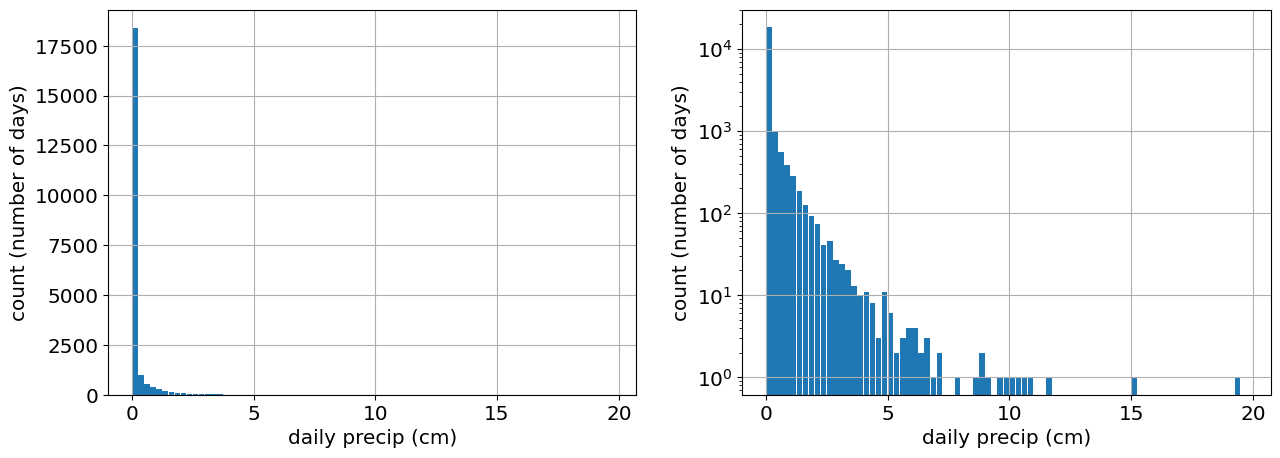

In [10]:
# Plot the histogram of the data. 
# For distributions such as a gamma distribution it makes sense to use a logarithmic axis.
#define bin edges and bin widths. 
# we'll use the maximum value in the data to define the upper limit

bin_edge_low=0
bin_edge_high=np.round(np.max(precip_raw)+1);
bin_width=0.25
bin_edges=np.arange(bin_edge_low,bin_edge_high,bin_width)

fig,ax=plt.subplots(1,2)
ax[0].hist(precip_raw,bin_edges,rwidth=0.9);
ax[0].set_xlabel('daily precip (cm)')
ax[0].set_ylabel('count (number of days)')
ax[0].grid()

ax[1].hist(precip_raw,bin_edges,rwidth=0.9)
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlabel('daily precip (cm)')
ax[1].set_ylabel('count (number of days)');

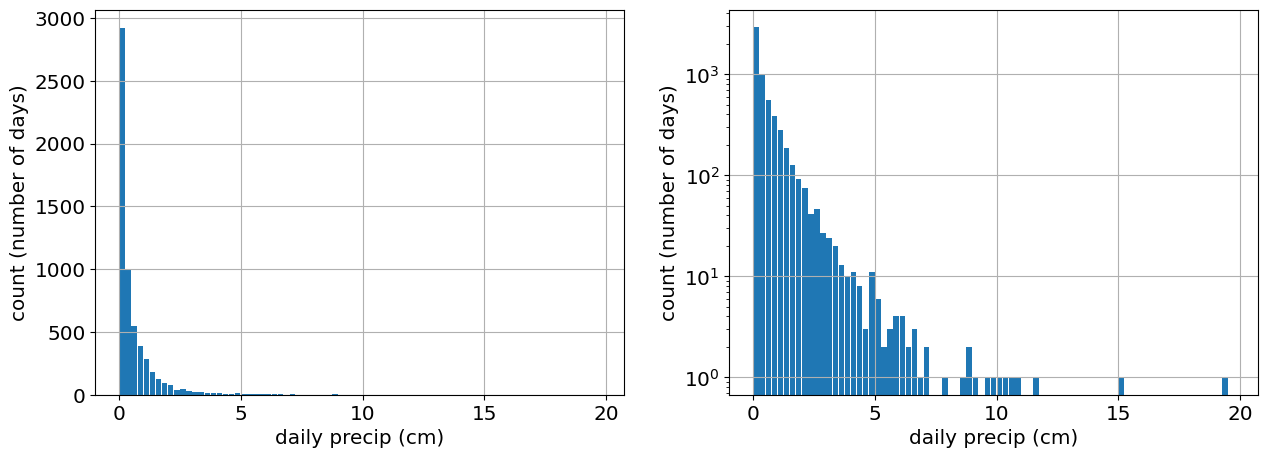

In [9]:
# the jump in the first bin indicates a probability mass at 0  ( a large number of days do not see any precipitation). 
# Let's only look at days when it rains. While we're at it, let's clean NaNs as well.
precip=precip_raw[precip_raw>0.01]

# Plot the histogram of the data
fig,ax=plt.subplots(1,2)
ax[0].hist(precip,bin_edges,rwidth=0.9);
ax[0].set_xlabel('daily precip (cm)')
ax[0].set_ylabel('count (number of days)')
ax[0].grid()
ax[0].set_xlabel('daily precip (cm)')
ax[0].set_ylabel('count (number of days)')

ax[1].hist(precip,bin_edges,rwidth=0.9)
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlabel('daily precip (cm)')
ax[1].set_ylabel('count (number of days)');


# Precipitation Return times
What we want is to compute the return time of the rainiest day recorded at Beaumont Research Center (in years). 

What does this mean? The rainiest day at Beaumont brought $x$ cm. The return time represents how often we would expect to get $x$ cm or more of rain at Beaumont. To compute the return time we need to compute the probability of daily rain >$x$ cm, i.e. $P(\text{daily rain}>x\text{ cm})$. The inverse of this probability is the frequency of daily rain >$x$ cm. Let's give some examples:

-  if the probability of daily rain > 3 cm is $P(\text{daily rain}>3\text{ cm})=1/30$, it means we would expect that it rains 3 cm or more once about every 30 day, and we would say 3 cm is a 30 day event. 

-  i the probability of daily rain > 50 cm is $P(\text{daily rain}>50\text{ cm})=1/36500$, it means we would expect that it rains 3 cm or more once about every 36500 days, or once every 100 years, and we would say 50 cm of rain is 100 year event.

-  The return time is thus the inverse of the probabiltiy of exceedence. I.e. the return time for a rain event $>3$cm is $1/P(\text{daily rain}>3\text{ cm})=30$ days. Similarly, ther return time for a rain event $>50$ cm is $1/P(\text{daily rain}>50\text{ cm})=100$ years.   

Remember that the probability of daily rain being *less* than $x$ cm is given by the cumulative distribution function (CDF): $P(\text{daily rain}<x\text{ cm})=F(x)$, so the probability of rain being *more* than x is given by $1-F(x)$, and thus the return time is:

$$ R(x)=\frac{1}{1-F(x)}$$
 
So, all we have to do is fit a distribution to the data, and then use its CDF to compute return times. 

# Return times via Gamma Distribution

Precipitation is often modelled as a gamma distribution. The probability of observing a value $x_i$ given the three parameters of the gamma distribution: shape, scale, and location, $\theta={\alpha,\beta,x_o}$ is 

$$ p(x_i|\alpha,\beta,x_{0})=\frac{1}{\Gamma(\alpha)\beta^{\alpha}}\left(x_{i}-x_{0}\right)^{\alpha-1}\exp\left(\frac{-\left(x-x_{0}\right)}{\beta}\right) $$

For N independent events, the log-likelihood is: 

$$ \log\mathcal{L}=\sum_{i=1}^{N}\left(-\log\Gamma(\alpha)-\alpha\log\beta+\left(\alpha-1\right)\log\left(x_{i}-x_{o}\right)-\frac{\left(x_{i}-x_{o}\right)}{\beta}\right)$$

The log-likelihood of the gamma distribution includes the Gamma function. Computing the derivatives of the log-likelihood and setting them to zero requires numerical estimation. In practice, we will rarely compute MLEs by hand. For example, to fit a gamma distribution, we will use the <code>stats.gamma.fit</code> method to obtain maximum likelihood estimates for the parameters. 

The method will output the three parameters of the gamma random variable, shape,scale, and location, denoted in scipy as <code>a,loc,scale</code>,  (see documentation <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html"> here</a>). So you'll need to call it as <code>alpha_mle,loc_mle,scale_mle=stats.gama.fit( .... )</code>


[0.20740010390299995, 0.019999999999999997, 2.2682740851535863]


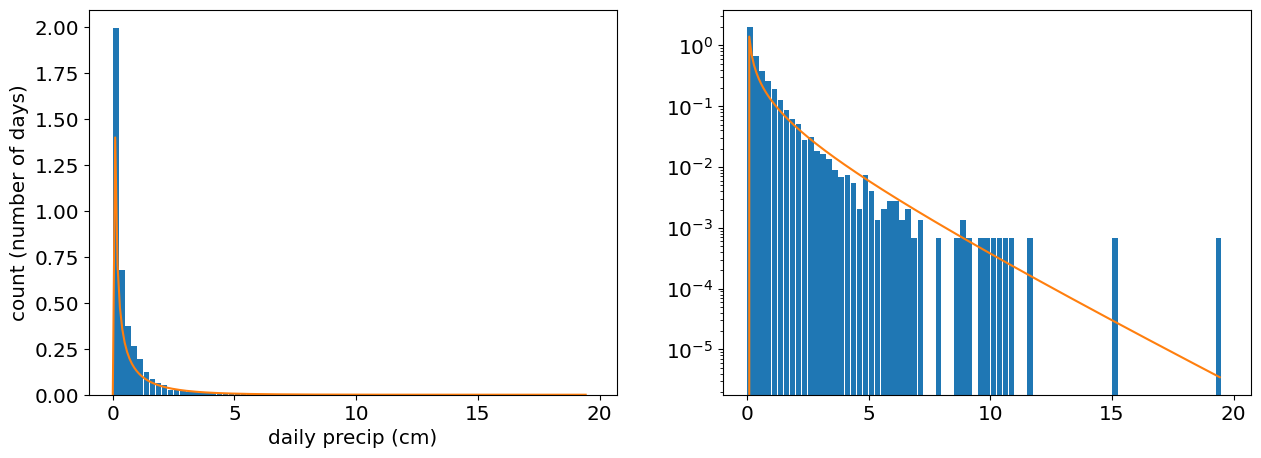

In [36]:
alpha_mle,loc_mle,scale_mle=stats.gamma.fit(precip,method='mle')
print([alpha_mle,loc_mle,scale_mle])
x_plot=np.linspace(0,np.max(precip),200)
gamma_pdf=stats.gamma.pdf(x_plot,alpha_mle,loc_mle,scale_mle)


# Plot the histogram of the data
fig,ax=plt.subplots(1,2)
ax[0].hist(precip,bin_edges,rwidth=0.9,density=True);
ax[0].set_xlabel('daily precip (cm)')
ax[0].set_ylabel('count (number of days)')

ax[1].hist(precip,bin_edges,rwidth=0.9,density=True)
ax[1].set_yscale('log')

ax[0].plot(x_plot,gamma_pdf);
ax[1].plot(x_plot,gamma_pdf);



Now that we have an mle estimate for $\theta={\alpha,\beta,l}$, we can estimate the return times of the as the inverse of the probabiltiy that rain is equal to or exceeds the maximum observed precip. 

$$ \text{return time} =\frac{1}{1-F(\max\{x\}|\alpha_{mle},\beta_{mle},l_{mle})}$$


In [25]:
# Return times for Beumont
prob=1-stats.gamma.cdf(np.max(precip),alpha_mle,loc_mle,scale_mle)

# compute the return time (in days) and convert to years
return_time_for_max=1/prob/365
print(return_time_for_max)


374.3981822070542


Let's plot this data

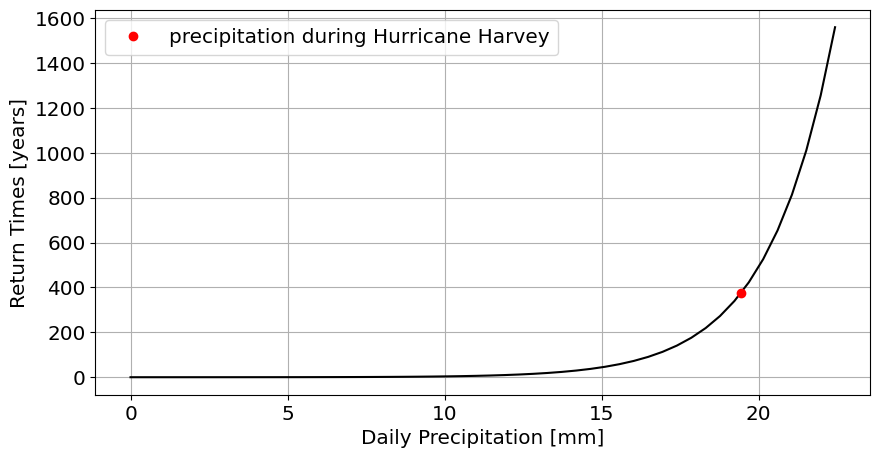

In [37]:
#support for cdf plot: let's go a bit beyond the maximum precipitation
x=np.linspace(0,np.max(precip)+3)
cdf=stats.gamma.cdf(x,alpha_mle,loc_mle,scale_mle)
return_times=1/(1-cdf)/365

figure,ax=plt.subplots(1,figsize=[10,5])
plt.plot(x,return_times,'k')
plt.plot(np.max(precip),return_time_for_max,'ro',label='precipitation during Hurricane Harvey');

plt.xlabel('Daily Precipitation [mm]')
plt.ylabel('Return Times [years]')
plt.grid()
plt.legend()

Let's repeat the analysis for the Port Arthur data. If you fit a Gamma ditribution and compute the return time of the largest daily rain event, what is the return time? 



[0.14266156687516424, 0.019999999999999997, 1.5504222901142262]


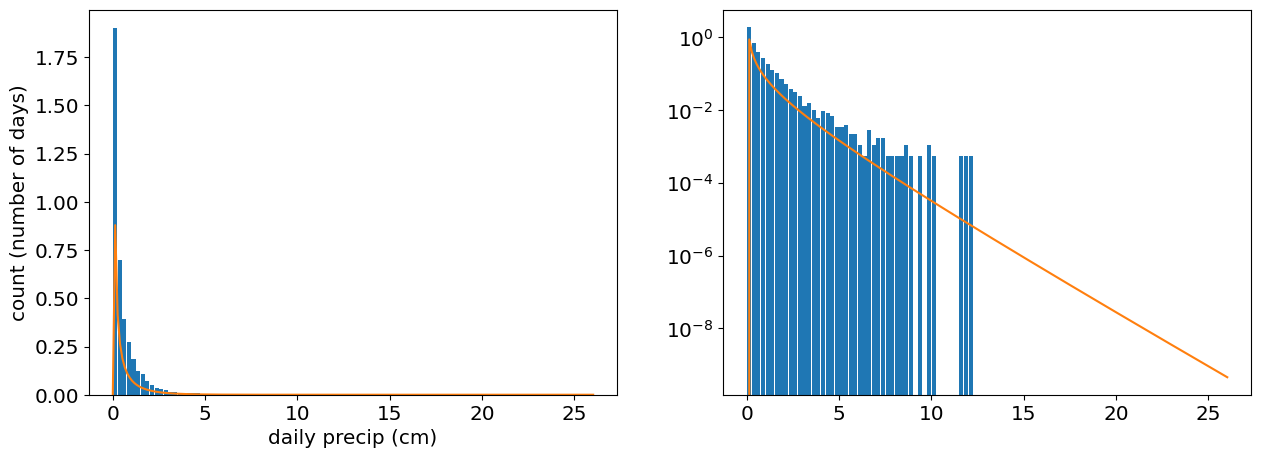

In [49]:
# read data and take a cursory look
df=pd.read_csv('https://raw.githubusercontent.com/cdds-uiuc/simles-book/main/content/Module02/data/PortArthur_precip.csv')
df.head()

# plot raw precipitation
precip_raw=df['PRCP'].values
precip_raw=precip_raw[np.isnan(precip_raw)==False] # take out nans
precip=precip_raw[precip_raw>0.01]

alpha_mle,loc_mle,scale_mle=stats.gamma.fit(precip,method='mle')
print([alpha_mle,loc_mle,scale_mle])

x_plot=np.linspace(0,np.max(precip),200)
gamma_pdf=stats.gamma.pdf(x_plot,alpha_mle,loc_mle,scale_mle)


# Plot the histogram of the data
fig,ax=plt.subplots(1,2)
ax[0].hist(precip,bin_edges,rwidth=0.9,density=True);
ax[0].set_xlabel('daily precip (cm)')
ax[0].set_ylabel('count (number of days)')

ax[1].hist(precip,bin_edges,rwidth=0.9,density=True)
ax[1].set_yscale('log')

ax[0].plot(x_plot,gamma_pdf)
ax[1].plot(x_plot,gamma_pdf)


In [50]:
prob=1-stats.gamma.cdf(np.max(precip),alpha_mle,loc_mle,scale_mle)
1/prob/365

4080713.548079735

Does that seem reasonable? Why do you think the statistical model fails here? Think of the type of precipitation events that make up the precipitation data at Port Arthur